In [1]:
import os
from collections import defaultdict
import numpy as np

log_dir = './logs'
experiment_logs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(list)))))

for filename in os.listdir(log_dir):
    if filename.endswith('.log'):
        parts = filename.split('-')
        method = '-'.join(parts[0:1])            
        experiment_name = '-'.join(parts[1:2])
        dataset = '-'.join(parts[2:3])
        nlist = '-'.join(parts[3:4])
        k = int('-'.join(parts[4:5]))
        if method == "ConANN":
            error = float(parts[5:6][0])
        else:
            error = float(parts[5:6][0][:-4])

        with open(os.path.join(log_dir, filename), 'r') as file:
            experiment_logs[experiment_name][method][dataset][k][error] = [float(line.strip()) for line in file.readlines()]

datasets = [j for j in experiment_logs['efficiency']['ConANN'].keys()]
print(datasets)
print(experiment_logs['error']['ConANN']['deep10M'][1000][0.2][:10])

data = experiment_logs['error']['ConANN']['deep10M'][100][0.1]
average = np.mean(data)
print(average)

['gist', 'sift1M', 'deep10M', 'bert', 'fasttext']
[0.47, 0.299, 0.184, 0.264, 0.305, 0.113, 0.5, 0.321, 0.053, 0.101]
0.100407499195


Error Value = 0.1:
  Dataset: bert
    Method: ConANN
      Average: nan
      Standard Deviation: nan
    Method: Faiss
      Average: 0.1141
      Standard Deviation: 0.2517

  Dataset: glove
    Method: ConANN
      Average: nan
      Standard Deviation: nan
    Method: Faiss
      Average: 0.0944
      Standard Deviation: 0.1786

  Dataset: sift1M
    Method: ConANN
      Average: 0.1006
      Standard Deviation: 0.1347
    Method: Faiss
      Average: 0.0935
      Standard Deviation: 0.1328

  Dataset: deep10M
    Method: ConANN
      Average: nan
      Standard Deviation: nan
    Method: Faiss
      Average: 0.0909
      Standard Deviation: 0.1503

Error Value = 0.2:
  Dataset: bert
    Method: ConANN
      Average: 0.1846
      Standard Deviation: 0.3703
    Method: Faiss
      Average: 0.2123
      Standard Deviation: 0.3181

  Dataset: glove
    Method: ConANN
      Average: 0.1920
      Standard Deviation: 0.2663
    Method: Faiss
      Average: 0.1844
      Standard Deviatio

/Users/sfhor/KTH/Projects/conann/plots/jupyter_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sfhor/KTH/Projects/conann/plots/jupyter_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/sfhor/KTH/Projects/conann/plots/jupyter_env/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sfhor/KTH/Projects/conann/plots/jupyter_env/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/sfhor/KTH/Projects/conann/plots/jupyter_env/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar

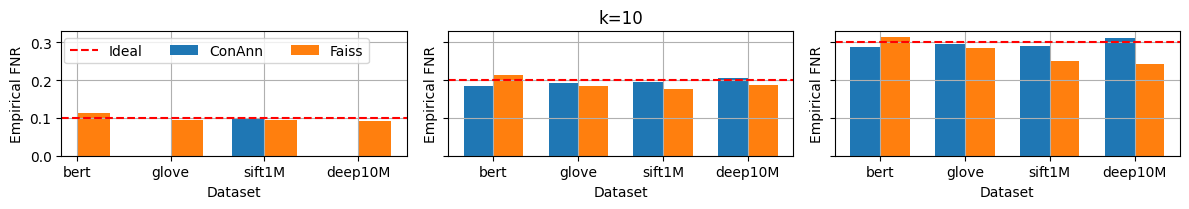

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Parameters to filter
# experiment_name = 'error'
# k_value = 100
# error_values = [0.1, 0.2, 0.3]  # Multiple error values
# target_datasets = ['bert', 'glove', 'sift1M', 'deep10M']  # Multiple datasets

# # Initialize a dictionary to store data for each error value and dataset
# data = {dataset: {error: {} for error in error_values} for dataset in target_datasets}

# # Extract data and calculate averages and standard deviations
# for method in experiment_logs[experiment_name]:
#     for dataset in experiment_logs[experiment_name][method]:
#         if dataset in target_datasets:  # Only process the target datasets
#             for error_value in error_values:
#                 try:
#                     values = experiment_logs[experiment_name][method][dataset][k_value][error_value]
#                     avg_value = np.mean(values)
#                     std_value = np.std(values)
#                     data[dataset][error_value][method] = {'avg': avg_value, 'std': std_value}
#                 except KeyError:
#                     continue

# # Plotting the bar charts
# fig, axes = plt.subplots(len(target_datasets), len(error_values), figsize=(10, 10))

# for i, dataset in enumerate(target_datasets):
#     for j, error_value in enumerate(error_values):
#         ax = axes[i, j] if len(target_datasets) > 1 else axes[j]
#         methods = list(data[dataset][error_value].keys())
#         averages = [data[dataset][error_value][method]['avg'] for method in methods]
#         std_devs = [data[dataset][error_value][method]['std'] for method in methods]
        
#         # Bar chart
#         ax.bar(methods, averages, yerr=std_devs, capsize=5)
#         ax.axhline(y=error_value, color='r', linestyle='--')
        
#         # Add title and labels
#         ax.set_title(f'{dataset} - Error {error_value}')
#         ax.set_ylabel('Average')
#         ax.set_xlabel('Method')
#         ax.set_xticklabels(methods, rotation=45)
#         # ax.legend(loc='upper right')
        
# plt.tight_layout()
# plt.show()

# # Optionally, print the results
# for dataset in target_datasets:
#     for error_value in error_values:
#         print(f"Dataset: {dataset}, Error Value = {error_value}:")
#         for method, stats in data[dataset][error_value].items():
#             print(f"  Method: {method}")
#             print(f"    Average: {stats['avg']:.4f}")
#             print(f"    Standard Deviation: {stats['std']:.4f}")
#         print()


import numpy as np
import matplotlib.pyplot as plt

# Parameters to filter
experiment_name = 'error'
k_value = 10
error_values = [0.1, 0.2, 0.3]  # Multiple error values
target_datasets = ['bert', 'glove', 'sift1M', 'deep10M']  # Multiple datasets

# Initialize a dictionary to store data for each error value and dataset
data = {error: {dataset: {} for dataset in target_datasets} for error in error_values}

# Extract data and calculate averages and standard deviations
for method in experiment_logs[experiment_name]:
    for dataset in experiment_logs[experiment_name][method]:
        if dataset in target_datasets:  # Only process the target datasets
            for error_value in error_values:
                try:
                    values = experiment_logs[experiment_name][method][dataset][k_value][error_value]
                    avg_value = np.mean(values)
                    std_value = np.std(values)
                    data[error_value][dataset][method] = {'avg': avg_value, 'std': std_value}
                except KeyError:
                    continue

# Plotting the bar charts by error value (alpha)
fig, axes = plt.subplots(1, len(error_values), figsize=(12, 2.2), sharey=True)

for j, error_value in enumerate(error_values):
    ax = axes[j]
    methods = ['ConANN', 'Faiss']  # Assuming you're interested in these methods
    width = 0.35  # Bar width

    # Prepare the positions for grouped bars
    x_positions = np.arange(len(target_datasets))
    conann_avgs = [data[error_value][dataset].get('ConANN', {}).get('avg', 0) for dataset in target_datasets]
    conann_std = [data[error_value][dataset].get('ConANN', {}).get('std', 0) for dataset in target_datasets]
    faiss_avgs = [data[error_value][dataset].get('Faiss', {}).get('avg', 0) for dataset in target_datasets]
    faiss_std = [data[error_value][dataset].get('Faiss', {}).get('std', 0) for dataset in target_datasets]

    # Plot bars for conann and faiss
    ax.bar(x_positions - width / 2, conann_avgs, width, label='ConAnn', capsize=5)
    ax.bar(x_positions + width / 2, faiss_avgs, width, label='Faiss', capsize=5)

    # Add titles and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(target_datasets, rotation=0)
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Empirical FNR')
    ax.axhline(y=error_value, color='r', linestyle='--', label=f'Ideal')
    ax.grid(True)
    
axes[0].legend(ncol=3, bbox_to_anchor=(0.45, 1), loc='upper center')

axes[1].set_title(f'k={k_value}')
plt.tight_layout()
# plt.show()
plt.savefig(f'validity-k={k_value}.pdf', format='pdf')

# Optionally, print the results
for error_value in error_values:
    print(f"Error Value = {error_value}:")
    for dataset in target_datasets:
        print(f"  Dataset: {dataset}")
        for method, stats in data[error_value][dataset].items():
            print(f"    Method: {method}")
            print(f"      Average: {stats['avg']:.4f}")
            print(f"      Standard Deviation: {stats['std']:.4f}")
        print()


In [41]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

# Parameters to filter
experiment_name = 'latency'  # Assuming the experiment name is 'efficiency'
k_value = 100
error_value = 0.2
target_dataset = 'glove'  # Filter for this dataset
# target_dataset = 'deep10M' 

# Extract data for the CDF
data = {}

for method in experiment_logs[experiment_name]:
    for dataset in experiment_logs[experiment_name][method]:
        if dataset == target_dataset:  # Only process the target dataset
            try:
                values = experiment_logs[experiment_name][method][dataset][k_value][error_value]
                data[method] = np.sort(values)  # Sort values for CDF calculation
            except KeyError:
                continue
                
for method, values in data.items():
    avg_latency = np.mean(values)
    print(f"Average latency for {method}: {avg_latency}")
    
# # Plotting the CDFs
# fig, ax = plt.subplots(figsize=(5, 2))

# # Plot CDF for each method
# for method, values in data.items():
#     # Calculate CDF
#     cdf = np.arange(1, len(values) + 1) / len(values)
#     ax.plot(values, cdf, label=method, linewidth=3)

# # Customize plot
# ax.set_title(f"Latency CDF for BERT (k={k_value}, α={error_value})")
# ax.set_xlabel('Latency (ms)')
# ax.set_ylabel('CDF')
# ax.legend(loc='upper left') #, bbox_to_anchor=(1, 1))
# ax.grid(True)

# # plt.tight_layout()
# plt.savefig(f'latency-bert-{k_value}-{error_value}.pdf')
# plt.show()

Average latency for ConANN: 11.359472331585845
Average latency for Faiss: 10.618609285


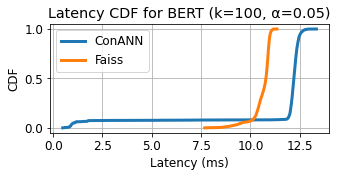

In [137]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

# Parameters to filter
experiment_name = 'latency'  # Assuming the experiment name is 'efficiency'
k_value = 100
error_value = 0.05
target_dataset = 'bert_100'  # Filter for this dataset
# target_dataset = 'deep10M' 

# Extract data for the CDF
data = {}

for method in experiment_logs[experiment_name]:
    for dataset in experiment_logs[experiment_name][method]:
        if dataset == target_dataset:  # Only process the target dataset
            try:
                values = experiment_logs[experiment_name][method][dataset][k_value][error_value]
                data[method] = np.sort(values)  # Sort values for CDF calculation
            except KeyError:
                continue
                
for method, values in data.items():
    avg_latency = np.mean(values)
    print(f"Average latency for {method}: {avg_latency}")
    
# Plotting the CDFs
fig, ax = plt.subplots(figsize=(5, 2))

# Plot CDF for each method
for method, values in data.items():
    # Calculate CDF
    cdf = np.arange(1, len(values) + 1) / len(values)
    ax.plot(values, cdf, label=method, linewidth=3)

# Customize plot
ax.set_title(f"Latency CDF for BERT (k={k_value}, α={error_value})")
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('CDF')
ax.legend(loc='upper left') #, bbox_to_anchor=(1, 1))
ax.grid(True)

# plt.tight_layout()
plt.savefig(f'latency-bert-{k_value}-{error_value}.pdf')
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# error_values = [0.05, 0.1, 0.2]
error_values = [0.1]
dataset = "deep10M"
k = 100

for error in error_values:
    print(f"\nError = {error}")
    
    # Step 1: Find Faiss clusters from the "efficiency" experiment
    faiss_clusters = experiment_logs['efficiency']['Faiss'][dataset][k][error]
    
    print(f"Clusters searched by FAISS: {faiss_clusters[0]}")
    
    # Step 2: Get IDs of methods where the clusters match Faiss
    matching_ids = {}
    for method in experiment_logs['efficiency']:
        if method != 'Faiss':  # Skip Faiss since we already have its clusters
            matching_ids[method] = []
            for idx, cluster in enumerate(experiment_logs['efficiency'][method][dataset][k][error]):
                if cluster == faiss_clusters[0]:  # match Faiss clusters
                    matching_ids[method].append(idx)

    # Step 3: Extract corresponding latency values from the "latency" experiment for other methods
    latency_values = {'Faiss': []}
    for idx, latency in enumerate(experiment_logs['latency']['Faiss'][dataset][k][error]):
        latency_values['Faiss'].append(latency)

    for method, ids in matching_ids.items():
        latency_values[method] = [experiment_logs['latency'][method][dataset][k][error][idx] for idx in ids]
        print(f"Method {method}; relevant queries {len(latency_values[method])}")

    # Step 4: Calculate average latencies and plot the difference
    avg_latency = {method: np.mean(latencies) for method, latencies in latency_values.items()}

    # Print average latency for Faiss and other methods
    for method, avg in avg_latency.items():
        print(f"{method}: Average Latency = {avg}")
        
    if 'ConANN' in avg_latency:
        faiss_avg = avg_latency['Faiss']
        conann_avg = avg_latency['ConANN']
        increase_percentage = ((conann_avg - faiss_avg) / faiss_avg) * 100
        print(f"ConANN: Latency Increase = {increase_percentage:.2f}%")


Error = 0.1
Clusters searched by FAISS: 11.0
Method ConANN; relevant queries 92
Faiss: Average Latency = 4.7795980049999995
ConANN: Average Latency = 273.4698871304348
ConANN: Latency Increase = 5621.61%



**** DATASET=bert *****
Abstention rate ConANN: 103

**** DATASET=glove *****
Abstention rate ConANN: 0

**** DATASET=sift1M *****
Abstention rate ConANN: 0

**** DATASET=deep10M *****
Abstention rate ConANN: 0

**** DATASET=gist *****
Abstention rate ConANN: 0


/Users/sfhor/KTH/Projects/conann/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sfhor/KTH/Projects/conann/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


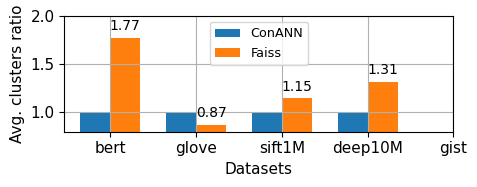

In [18]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11}) 

# Parameters to filter
experiment_name = 'efficiency'
k_value = 100
error_value = 0.1
target_datasets = ['bert', 'glove', 'sift1M', 'deep10M', 'gist']

# Data storage
clusters_ratio_per_method = {dataset: [] for dataset in target_datasets}
methods = ['ConANN', 'Faiss']

# Extract data for the ratio computation
for idx, target_dataset in enumerate(target_datasets):
    print(f"\n**** DATASET={target_dataset} *****")
    data = {}
    conann_avg = None  # Store ConANN average for the current dataset
    for method in experiment_logs[experiment_name]:
        for dataset in experiment_logs[experiment_name][method]:
            if dataset == target_dataset:
                try:
                    values = experiment_logs[experiment_name][method][dataset][k_value][error_value]
                    if method == 'ConANN':
                        count_minus_one = values.count(-1)
                        values = [v for v in values if v != -1]
                        print("Abstention rate ConANN:", count_minus_one)  # Output the count of -1 values
                    data[method] = np.sort(values)
                except KeyError:
                    continue
    
    # Compute ConANN average for the baseline
    if 'ConANN' in data:
        conann_avg = np.mean(data['ConANN'])

    # Compute clusters ratio for each method based on the ConANN baseline
    for method in methods:
        if method in data and conann_avg is not None:
            avg_clusters = np.mean(data[method])
            # Compute ratio relative to the ConANN baseline
            ratio = avg_clusters / conann_avg
            clusters_ratio_per_method[target_dataset].append(ratio)

# Plot the bar chart for clusters ratio
fig, ax = plt.subplots(figsize=(5, 2))
bar_width = 0.35
index = np.arange(len(target_datasets))

# method_colors = {'ConANN': 'blue', 'Faiss': 'orange'}

# Create bars for each method
for i, method in enumerate(methods):
    bars = ax.bar(index + i * bar_width, 
                  [clusters_ratio_per_method[dataset][i] for dataset in target_datasets],
                  bar_width, label=method) # color=method_colors[method])

    # Annotate Faiss bars with the ratio values on top
    if method == 'Faiss':
        for j, bar in enumerate(bars):
            ratio_value = clusters_ratio_per_method[target_datasets[j]][i]
            ax.text(bar.get_x() + bar.get_width() / 2, 
                    bar.get_height() + 0.05,  # Adjust 0.05 to position the text above the bar
                    f'{ratio_value:.2f}',  # Format the ratio with 2 decimal places
                    ha='center', va='bottom', fontsize=10)

# Add labels and title
ax.set_xlabel('Datasets')
ax.set_ylabel('Avg. clusters ratio')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(target_datasets)
ax.legend(fontsize='small')
ax.grid(True)
ax.set_ylim(0.8, 2) 

plt.tight_layout()
plt.savefig(f'efficiency_k={k_value}_alpha={error_value}.pdf', format='pdf')
plt.show()

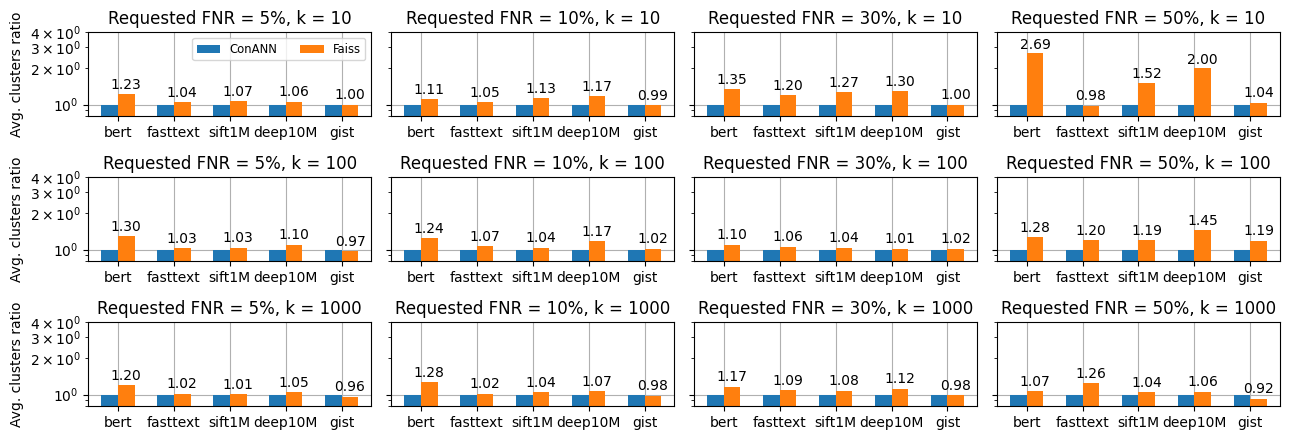

In [52]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

experiment_name = 'efficiency'
k_values = [10, 100, 1000]  # List of k values
error_values = [0.05, 0.1, 0.3, 0.5]  # List of error values
target_datasets = ['bert', 'fasttext', 'sift1M', 'deep10M', 'gist']
methods = ['ConANN', 'Faiss']
fig, axes = plt.subplots(len(k_values), len(error_values), figsize=(13, len(k_values) * 1.5), sharey=True)

for k_idx, k_value in enumerate(k_values):
    for error_idx, error_value in enumerate(error_values):
        ax = axes[k_idx, error_idx]
        
        clusters_ratio_per_method = {dataset: [] for dataset in target_datasets}
        method_averages = {method: [] for method in methods}

        for target_dataset in target_datasets:
            data = {}
            conann_avg = None  # Store ConANN average for the current dataset
            for method in experiment_logs[experiment_name]:
                for dataset in experiment_logs[experiment_name][method]:
                    if dataset == target_dataset:
                        try:
                            values = experiment_logs[experiment_name][method][dataset][k_value][error_value]
                            if method == 'ConANN':
                                count_minus_one = values.count(-1)
                                values = [v for v in values if v != -1]
                            data[method] = np.sort(values)
                        except KeyError:
                            continue

            if 'ConANN' in data:
                conann_avg = np.mean(data['ConANN'])

            # Compute clusters ratio for each method based on the ConANN baseline
            for method in methods:
                if method in data and conann_avg is not None:
                    avg_clusters = np.mean(data[method])
                    ratio = avg_clusters / conann_avg
                    clusters_ratio_per_method[target_dataset].append(ratio)
                    method_averages[method].append(avg_clusters)

        bar_width = 0.3
        index = np.arange(len(target_datasets))

        for i, method in enumerate(methods):
            bars = ax.bar(index + i * bar_width, 
                          [clusters_ratio_per_method[dataset][i] for dataset in target_datasets],
                          bar_width, label=method)

            if method == 'Faiss':
                for j, bar in enumerate(bars):
                    ratio_value = clusters_ratio_per_method[target_datasets[j]][i]
                    ax.text(bar.get_x() + bar.get_width() / 2, 
                            bar.get_height() + 0.05,  
                            f'{ratio_value:.2f}',  
                            ha='center', va='bottom', fontsize=10)

        ax.set_title(f'Requested FNR = {int(error_value * 100)}%, k = {k_value}')
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(target_datasets)
        ax.grid(True)
        ax.set_ylim(0.8, 4)
        ax.set_yscale('log')
        ax.set_axisbelow(True)

        if error_idx == 0:
            ax.set_ylabel('Avg. clusters ratio')

axes[0, 0].legend(fontsize='small', loc='upper right', ncol=2)

plt.tight_layout()
plt.savefig(f'efficiency_all.pdf', format='pdf')
plt.show()
